## Bayesian SOT (static)

This code retrieves a surface map from reflection integrated light curve of an Earth analog based on a Bayesian modeling conditioned on hyperparameters and nonlinear parameters.

- Section 2 in Kawahara and Masuda 2020

See also
- Farr et al. 2018 
- Kawahara & Fujii 2010 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1004.5152)
- Kawahara & Fujii 2011 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1106.0136)
- Fujii & Kawahara 2012 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1204.3504)

for more details.  You need Healpy, Scikit-learn, sot package https://github.com/HajimeKawahara/sot.
Add sot/sot/core in your PYTHONPATH.

Here, we will consider three-types of the kernel, L2, RBF, and Matern-3/2.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import healpy as hp
import pylab 
import matplotlib.pyplot as plt
import time
import mocklc #Use mocklc module in sot package. 
np.random.seed(57)

In [4]:
#set geometry
inc=45.0/180.0*np.pi
Thetaeq=np.pi
#zeta=np.pi/3.0
zeta=23.4/180.0*np.pi                                                                                               
Pspin=23.9344699/24.0 #Pspin: a sidereal day                                                                                                                                                                                                               
wspin=2*np.pi/Pspin                                                                                                          
Porb=365.242190402                                            
#Porb=40.0
worb=2*np.pi/Porb                                                                                                                
Ni=1024
obst=np.linspace(0.0,Porb,Ni)

NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


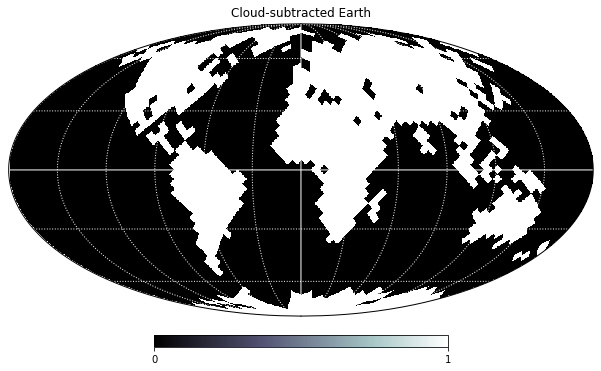

In [5]:
# test map
nside=16
npix=hp.nside2npix(nside)
mmap=hp.read_map("/home/kawahara/exomap/sot/data/mockalbedo16.fits")
mask=(mmap>0.0)
mmap[mask]=1.0
hp.mollview(mmap, title="Cloud-subtracted Earth",flip="geo",cmap=plt.cm.bone,min=0,max=1)
#hp.mollview(Kvolall,title="Kvol",flip="geo",cmap=plt.cm.Spectral,min=-0.3,max=0.3)
hp.graticule(color="white");
M=len(mmap)

In [6]:
#generating light curve
Thetav=worb*obst
Phiv=np.mod(wspin*obst,2*np.pi)
WI,WV=mocklc.comp_weight(nside,zeta,inc,Thetaeq,Thetav,Phiv)
W=WV[:,:]*WI[:,:]
lc=np.dot(W,mmap)

sigma=np.mean(lc)*0.01
noise=np.random.normal(0.0,sigma,len(lc))
lc=lc+noise

No handles with labels found to put in legend.


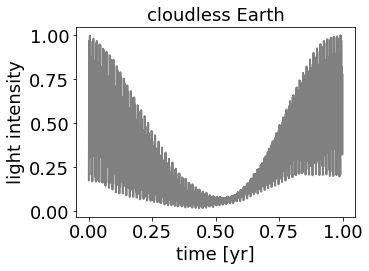

In [39]:
fig= plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111)
ax.plot(obst/obst[-1],lc/np.max(lc),lw=2,color="gray")
plt.legend(loc="upper right",prop={'size':11},frameon=False)
plt.tick_params(labelsize=18)
plt.ylabel("light intensity",fontsize=18)
plt.xlabel("time [yr]",fontsize=18)
plt.title("cloudless Earth",fontsize=18)
plt.savefig("sotlc.png", bbox_inches="tight", pad_inches=0.0)
plt.show()


In [8]:
import matplotlib
fontsize=20
matplotlib.rcParams.update({'font.size':fontsize})

## Ridge/L2 

In [9]:
#posterior
lam=2.0
A=np.linalg.inv(W.T@W + lam*lam*np.eye(npix))
mu=A@W.T@lc
cov=sigma**2*A

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


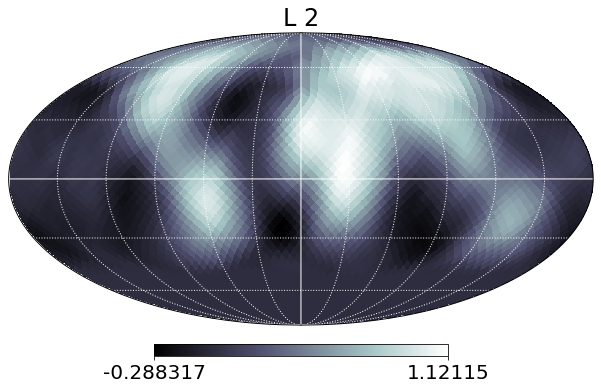

In [10]:
#best map
hp.mollview(mu, title="L 2",flip="geo",cmap=plt.cm.bone)#,min=0,max=1.0)
hp.graticule(color="white");
plt.savefig("sotl2map.pdf", bbox_inches="tight", pad_inches=0.0)

In [11]:
# random realization
randmap=np.random.multivariate_normal(mu,cov,npix)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


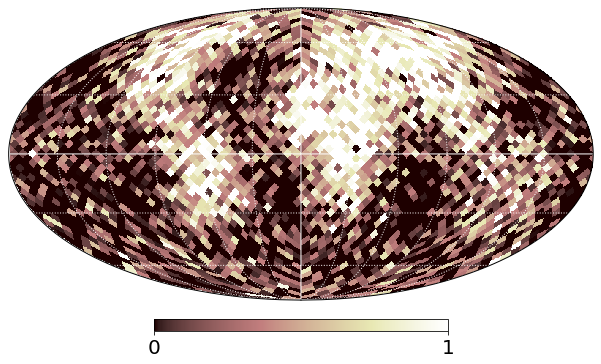

In [12]:
# pick a sample 
hp.mollview(randmap[50,:], title="",flip="geo",cmap=plt.cm.pink,min=0,max=1.0)
hp.graticule(color="white")
plt.savefig("sotl2pick.pdf", bbox_inches="tight", pad_inches=0.0);

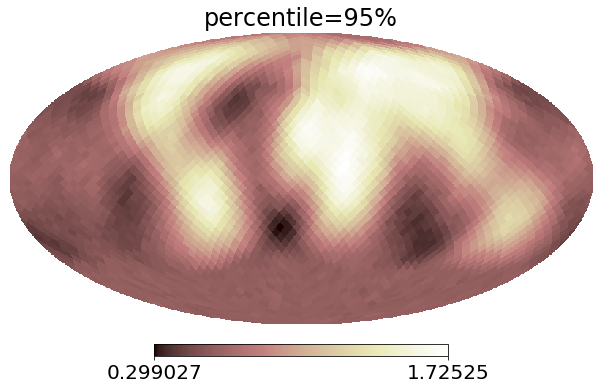

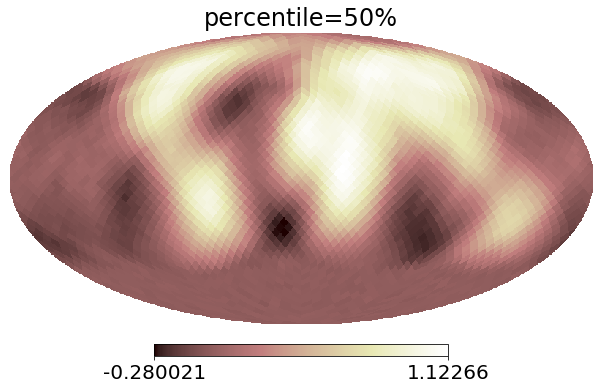

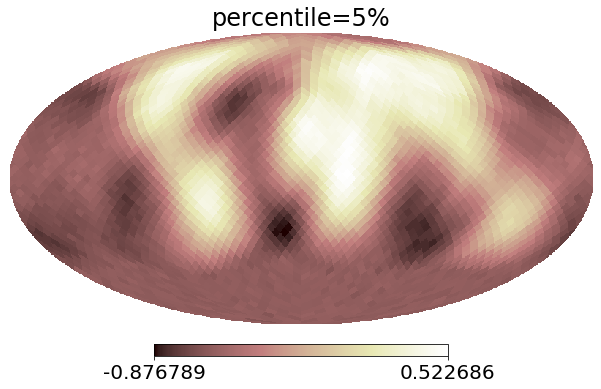

In [22]:
#percentile maps
up=95
down=5
med=50
Ncreup=np.zeros(npix)
Ncredown=np.zeros(npix)
Ncremed=np.zeros(npix)

for n in range(0,npix):
    Ncreup[n]=np.percentile(randmap[:,n], up)
    Ncredown[n]=np.percentile(randmap[:,n], down)
    Ncremed[n]=np.percentile(randmap[:,n], med)

hp.mollview(Ncreup, title="percentile="+str(up)+"%",flip="geo",cmap=plt.cm.pink)
hp.mollview(Ncremed, title="percentile="+str(med)+"%",flip="geo",cmap=plt.cm.pink)
hp.mollview(Ncredown, title="percentile="+str(down)+"%",flip="geo",cmap=plt.cm.pink)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


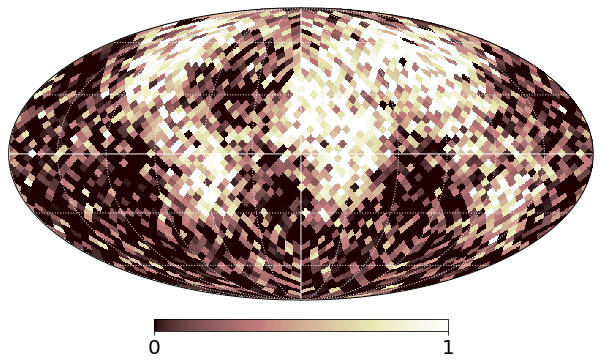

In [19]:
#randomized map
hp.mollview(np.diagonal(randmap), title="",flip="geo",cmap=plt.cm.pink,min=0,max=1.0)
hp.graticule(color="white");
plt.savefig("sotl2rand.pdf", bbox_inches="tight", pad_inches=0.0);

## RBF kernel

In [23]:
import sepmat 
import gpkernel 
import scipy

In [24]:
sep=sepmat.calc_sepmatrix(nside)

In [25]:
gamma=0.32470597615966523
alpha=0.4172890000949949
KS=alpha*gpkernel.RBF(sep,gamma)

In [26]:
#posterior
PiS=np.linalg.inv(KS)
A=np.linalg.inv(W.T@W + PiS)
cov=sigma**2*A

Nt=len(obst)
Kw=W@KS@W.T
Xlc=scipy.linalg.solve(np.eye(Nt)+Kw,lc,assume_a="pos")
mu=KS@W.T@Xlc

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


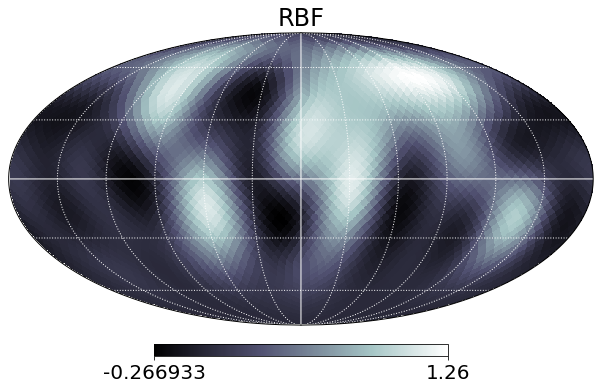

In [27]:
#best map
hp.mollview(mu, title="RBF",flip="geo",cmap=plt.cm.bone)#,min=0,max=1.0)
hp.graticule(color="white");
plt.savefig("sotrbfmap.pdf", bbox_inches="tight", pad_inches=0.0);

In [28]:
randmap=np.random.multivariate_normal(mu,cov,npix)

/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """Entry point for launching an IPython kernel.


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


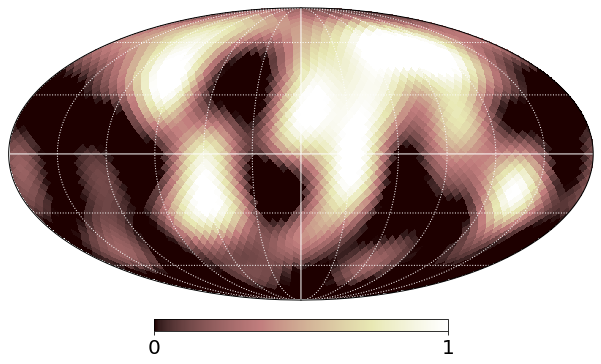

In [29]:
#pick a sample
hp.mollview(randmap[57,:], title="",flip="geo",cmap=plt.cm.pink,min=0,max=1)
hp.graticule(color="white");
plt.savefig("sotrbfpick.pdf", bbox_inches="tight", pad_inches=0.0);

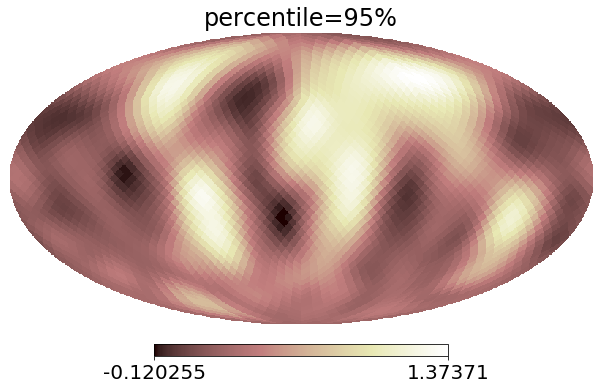

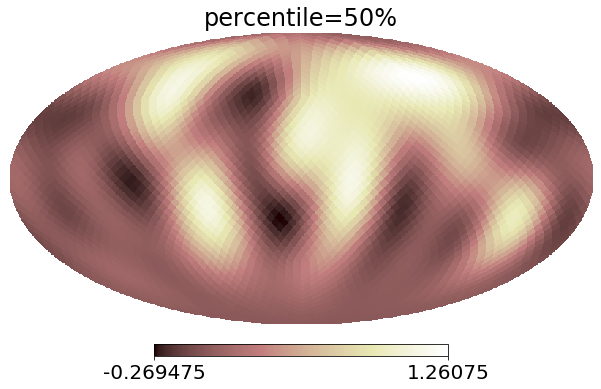

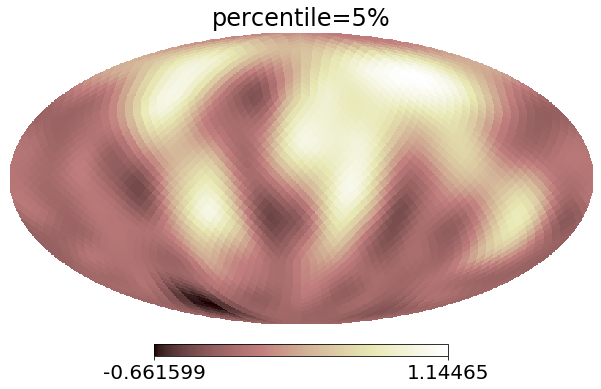

In [30]:
#percentile maps
up=95
down=5
med=50
Ncreup=np.zeros(npix)
Ncredown=np.zeros(npix)
Ncremed=np.zeros(npix)

for n in range(0,npix):
    Ncreup[n]=np.percentile(randmap[:,n], up)
    Ncredown[n]=np.percentile(randmap[:,n], down)
    Ncremed[n]=np.percentile(randmap[:,n], med)

hp.mollview(Ncreup, title="percentile="+str(up)+"%",flip="geo",cmap=plt.cm.pink)
hp.mollview(Ncremed, title="percentile="+str(med)+"%",flip="geo",cmap=plt.cm.pink)
hp.mollview(Ncredown, title="percentile="+str(down)+"%",flip="geo",cmap=plt.cm.pink)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


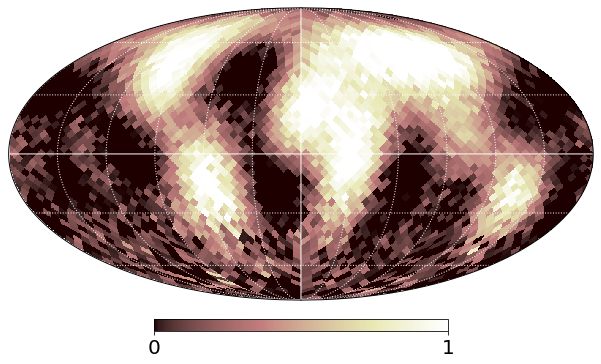

In [31]:
#randomized map
hp.mollview(np.diagonal(randmap), title="",flip="geo",cmap=plt.cm.pink,min=0,max=1.0)
hp.graticule(color="white");
plt.savefig("sotrbfrand.pdf", bbox_inches="tight", pad_inches=0.0);

## Matern -3/2

In [32]:
gamma=0.4629825742550962
alpha=0.4775753187200252
KS=alpha*gpkernel.Matern32(sep,gamma)

In [33]:
#posterior
PiS=np.linalg.inv(KS)
A=np.linalg.inv(W.T@W + PiS)
cov=sigma**2*A

Nt=len(obst)
Kw=W@KS@W.T
Xlc=scipy.linalg.solve(np.eye(Nt)+Kw,lc,assume_a="pos")
mu=KS@W.T@Xlc

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


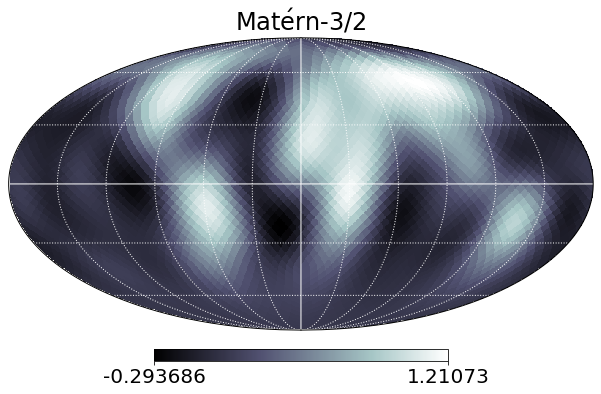

In [34]:
#best map
hp.mollview(mu, title="Mat$\\acute{\mathrm{e}}$rn-3/2",flip="geo",cmap=plt.cm.bone)#,min=0,max=1.0)
hp.graticule(color="white");
plt.savefig("sotmatmap.pdf", bbox_inches="tight", pad_inches=0.0);

In [35]:
randmap=np.random.multivariate_normal(mu,cov,npix)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


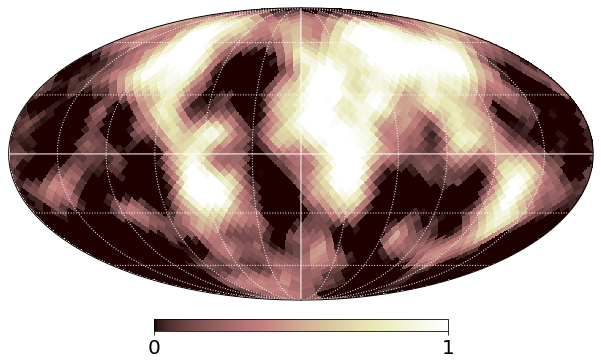

In [36]:
#pick a sample
hp.mollview(randmap[57,:], title="",flip="geo",cmap=plt.cm.pink,min=0,max=1.0)
hp.graticule(color="white");
plt.savefig("sotmatpick.pdf", bbox_inches="tight", pad_inches=0.0);

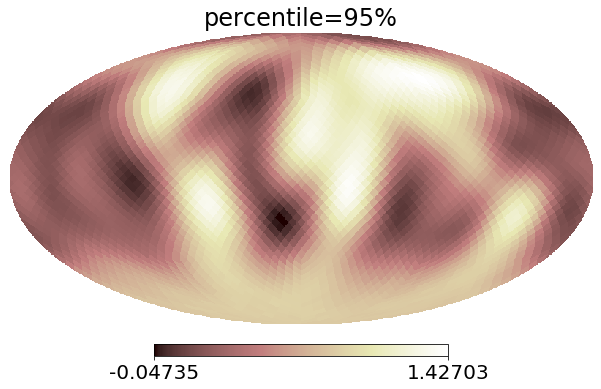

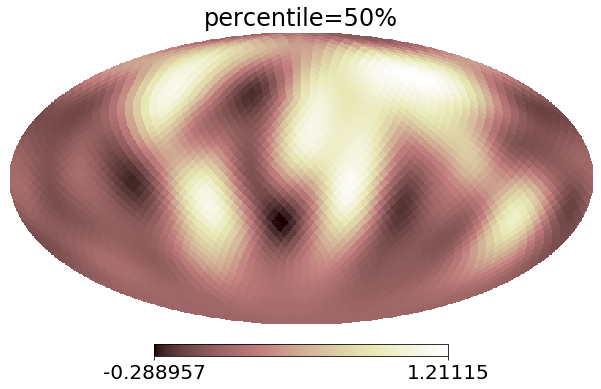

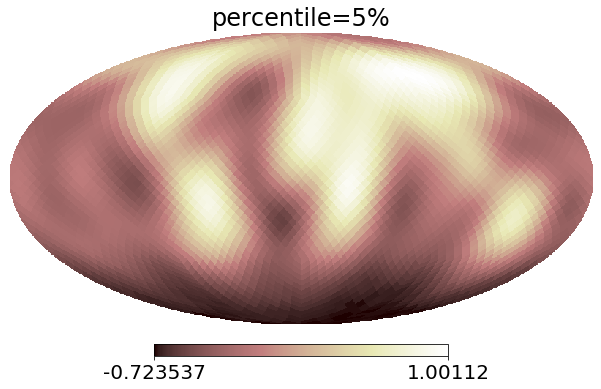

In [37]:
#percentile maps
up=95
down=5
med=50
Ncreup=np.zeros(npix)
Ncredown=np.zeros(npix)
Ncremed=np.zeros(npix)

for n in range(0,npix):
    Ncreup[n]=np.percentile(randmap[:,n], up)
    Ncredown[n]=np.percentile(randmap[:,n], down)
    Ncremed[n]=np.percentile(randmap[:,n], med)

hp.mollview(Ncreup, title="percentile="+str(up)+"%",flip="geo",cmap=plt.cm.pink)
hp.mollview(Ncremed, title="percentile="+str(med)+"%",flip="geo",cmap=plt.cm.pink)
hp.mollview(Ncredown, title="percentile="+str(down)+"%",flip="geo",cmap=plt.cm.pink)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


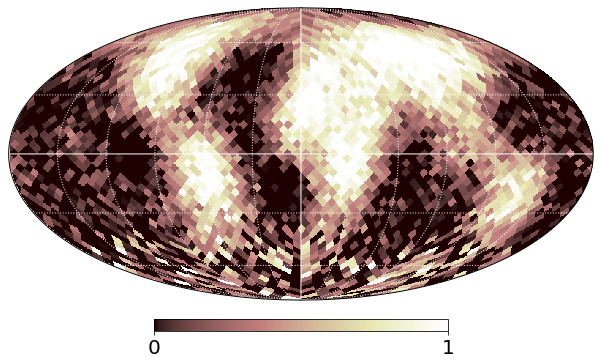

In [38]:
#randmized map
hp.mollview(np.diagonal(randmap), title="",flip="geo",cmap=plt.cm.pink,min=0,max=1.0)
hp.graticule(color="white");
plt.savefig("sotmatrand.pdf", bbox_inches="tight", pad_inches=0.0);